# GF-KSD: Convergence Detection (different $p$)

In this example we consider convergence detection of GF-KSD. Here, the sequences considered will be sequences of tempered distributions:

$$ \log \pi_n(x) = \epsilon_n\log \pi_0(x) + (1-\epsilon_n) \log u(x), $$

where $u$ is a distribution and $(\epsilon_n)_{n=1}^{100}$ is a tempering sequence.

In [3]:
import torch
import numpy as np
import torch.distributions as D

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import style
style.use("seaborn-white")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from pylab import rcParams
rcParams['figure.figsize'] = 10,6

from matplotlib import cm
import numpy as np

from steintorch.utils.get_score import get_score
from steintorch.utils.dist_approximations import get_gaussian_mixture_approximation, get_laplace_approximation, get_kernel_density_approximation
from steintorch.kernel import SquaredExponentialKernel
from steintorch.distribution.base import Distribution

color_map = cm.rainbow

## Defining $p$:

We consider two targets:

In [4]:
weights1 = torch.Tensor([0.5,0.5,0.5,0.1])
mean_vec1 = torch.Tensor([[-0.3],[0],[0.3],[0]])
var_vec1 = torch.Tensor([[0.1],[0.05],[0.1],[1]])

mix1 = D.Categorical(weights1)
normal1 = D.Normal(mean_vec1, var_vec1)
comp1 = D.Independent(normal1, 1)
P1 = D.MixtureSameFamily(mix1, comp1)

In [5]:
weights2 = torch.Tensor([0.1,0.2,0.3,0.4])
mean_vec2 = torch.Tensor([[-0.4],[-0.2],[0],[0.3]])
var_vec2 = torch.Tensor([[0.05],[0.1],[0.1],[0.3]])

mix2 = D.Categorical(weights2)
studentt2 = D.StudentT(10, mean_vec2, var_vec2)
comp2 = D.Independent(studentt2, 1)
P2 = D.MixtureSameFamily(mix2, comp2)

## Defining Sequences:

In [7]:
from steintorch.distribution.base import Distribution

N = 100

def tempered_sequence(epsilon, target_dist, tempered_dist):
    Q_n = Distribution()

    def log_prob_Q_n(x):
        return epsilon * tempered_dist.log_prob(x).flatten() + (1 - epsilon) * target_dist.log_prob(x).flatten()
        
    Q_n.log_prob = log_prob_Q_n
    return Q_n


epsilon_seq1 = torch.linspace(1,0,N + 2).pow(2)[1:-1]
epsilon_seq2 = torch.linspace(1,0, N + 2).pow(2.5)[1:-1]
epsilon_seq3 = torch.linspace(1,0, N + 2).pow(3)[1:-1]

epsilons_seqs = [epsilon_seq1, epsilon_seq2, epsilon_seq3]

tempering_dist1 = D.Normal(torch.Tensor([0]), torch.Tensor([0.6]))
tempering_dist2 = D.Normal(torch.Tensor([-0.05]), torch.Tensor([0.05]))
tempering_dist3 = D.Normal(torch.Tensor([0.7]), torch.Tensor([0.1]))

tempering_dists = [tempering_dist1, tempering_dist2, tempering_dist3]

bad_target = D.Normal(torch.Tensor([0]), torch.Tensor([0.4]))

Plotting the tempering sequences:

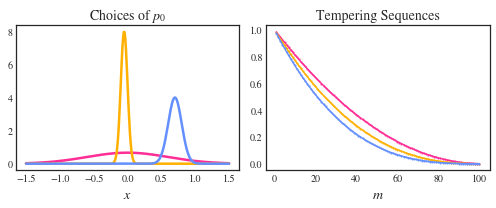

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(7,3))

m_seq = torch.linspace(1, 100, 100)

LIN = torch.linspace(-1.5,1.5,300)

axes[0].set_title('Choices of $p_0$', fontsize=14)
axes[0].plot(LIN, tempering_dist1.log_prob(LIN.unsqueeze(1)).flatten().exp(), label='$\epsilon^1_m$', color='#FF2D96', linewidth=2.5)
axes[0].plot(LIN, tempering_dist2.log_prob(LIN.unsqueeze(1)).flatten().exp(), label='$\epsilon^2_m$', color='#FFB000', linewidth=2.5)
axes[0].plot(LIN, tempering_dist3.log_prob(LIN.unsqueeze(1)).flatten().exp(), label='$\epsilon^3_m$', color='#648FFF', linewidth=2.5)
axes[0].set_xlabel('$x$', fontsize=14)

axes[1].set_title('Tempering Sequences', fontsize=14)
axes[1].plot(m_seq, epsilon_seq1, marker='.', markersize=2, label='$\epsilon^1_m$', color='#FF2D96')
axes[1].plot(m_seq, epsilon_seq2, marker='.', markersize=2, label='$\epsilon^2_m$', color='#FFB000')
axes[1].plot(m_seq, epsilon_seq3, marker='.', markersize=2, label='$\epsilon^3_m$', color='#648FFF')
axes[1].set_xlabel('$m$', fontsize=14)

fig.tight_layout()

### Plotting Sequences:

In [11]:
cm_lin_space = np.linspace(0, 1, N) ** 0.2

def make_Ramp( ramp_colors ): 
    from colour import Color
    from matplotlib.colors import LinearSegmentedColormap
    N = 100
    cm_lin_space = np.linspace(0, 1, N) ** 0.2

    color_ramp = LinearSegmentedColormap.from_list( 'my_list', [ Color( c1 ).rgb for c1 in ramp_colors ] )
    plt.figure( figsize = (15,3))
    plt.imshow( [list(cm_lin_space * len(ramp_colors))], interpolation='nearest', origin='lower', cmap= color_ramp )
    plt.xticks([])
    plt.yticks([])
    return color_ramp

good_ramp1 = make_Ramp( ['#19040F','#FF2D96' ] ) 
good_ramp2 =  make_Ramp( ['#191100','#FFB000' ] ) 
good_ramp3 = make_Ramp( ['#0A0E19','#648FFF' ] ) 

good_ramps = [good_ramp1, good_ramp2, good_ramp3]

/var/folders/y9/f2jq2rkn6h16kl4g9j02c2800000gn/T/ipykernel_27979/987965817.py:51: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "padding" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig("sequence_p1.pdf", bbox_inches = "tight", padding = 0)


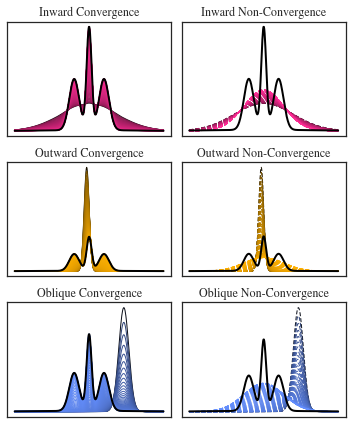

In [12]:
N = len(epsilon_seq1)
LIN = torch.linspace(-1.5,1.5,400)

fig, axes = plt.subplots(3,2)
fig.set_size_inches(5, 6)

ls = "--"

THICKNESS = 1

for j in range(3):
    for i in range(N):
        Q_ij = tempered_sequence(epsilons_seqs[j][i], target_dist=P1, tempered_dist=tempering_dists[j])
        axes[j][0].plot(LIN, Q_ij.log_prob(LIN.unsqueeze(-1)).exp(), color=good_ramps[j](cm_lin_space[i]), linewidth=THICKNESS)

    axes[j][0].plot(LIN, P1.log_prob(LIN.unsqueeze(-1)).exp(), color="black", linewidth=THICKNESS+1)


for j in range(3):
    for i in range(N):
        Q_ij = tempered_sequence(epsilons_seqs[j][i], target_dist=bad_target, tempered_dist=tempering_dists[j])
        axes[j][1].plot(LIN, Q_ij.log_prob(LIN.unsqueeze(-1)).exp(), color=good_ramps[j](cm_lin_space[i]), linewidth=THICKNESS, linestyle=ls, dashes=[4, 2])

    axes[j][1].plot(LIN, P1.log_prob(LIN.unsqueeze(-1)).exp(), color="black", linewidth=THICKNESS+1)


axes[0][0].set_title("Inward Convergence")
axes[1][0].set_title("Outward Convergence")
axes[2][0].set_title("Oblique Convergence")

axes[0][1].set_title("Inward Non-Convergence")
axes[1][1].set_title("Outward Non-Convergence")
axes[2][1].set_title("Oblique Non-Convergence")

for i in range(3):
    #axes[i][1].set_xticks([])
    axes[i][1].xaxis.set_ticks_position('none') 
    axes[i][1].set_xticklabels([])
    #axes[i][0].set_xticks([])
    axes[i][0].xaxis.set_ticks_position('none') 
    axes[i][0].set_xticklabels([])

    #axes[i][1].set_yticks([])
    axes[i][1].yaxis.set_ticks_position('none') 
    axes[i][1].set_yticklabels([])
    axes[i][0].yaxis.set_ticks_position('none') 
    axes[i][0].set_yticklabels([])

fig.tight_layout()    

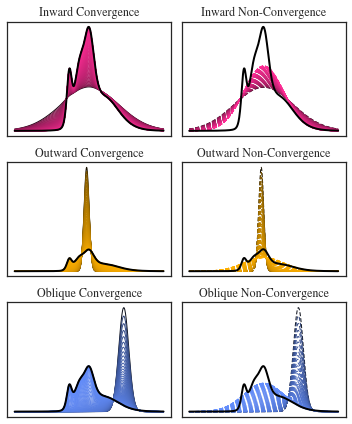

In [13]:
N = len(epsilon_seq1)
LIN = torch.linspace(-1.5,1.5,400)

fig, axes = plt.subplots(3,2)
fig.set_size_inches(5, 6)

ls = "--"

THICKNESS = 1

for j in range(3):
    for i in range(N):
        Q_ij = tempered_sequence(epsilons_seqs[j][i], target_dist=P2, tempered_dist=tempering_dists[j])
        axes[j][0].plot(LIN, Q_ij.log_prob(LIN.unsqueeze(-1)).exp(), color=good_ramps[j](cm_lin_space[i]), linewidth=THICKNESS)

    axes[j][0].plot(LIN, P2.log_prob(LIN.unsqueeze(-1)).exp(), color="black", linewidth=THICKNESS+1)


for j in range(3):
    for i in range(N):
        Q_ij = tempered_sequence(epsilons_seqs[j][i], target_dist=bad_target, tempered_dist=tempering_dists[j])
        axes[j][1].plot(LIN, Q_ij.log_prob(LIN.unsqueeze(-1)).exp(), color=good_ramps[j](cm_lin_space[i]), linewidth=THICKNESS, linestyle=ls, dashes=[4, 2])

    axes[j][1].plot(LIN, P2.log_prob(LIN.unsqueeze(-1)).exp(), color="black", linewidth=THICKNESS+1)


axes[0][0].set_title("Inward Convergence")
axes[1][0].set_title("Outward Convergence")
axes[2][0].set_title("Oblique Convergence")

axes[0][1].set_title("Inward Non-Convergence")
axes[1][1].set_title("Outward Non-Convergence")
axes[2][1].set_title("Oblique Non-Convergence")

for i in range(3):
    #axes[i][1].set_xticks([])
    axes[i][1].xaxis.set_ticks_position('none') 
    axes[i][1].set_xticklabels([])
    #axes[i][0].set_xticks([])
    axes[i][0].xaxis.set_ticks_position('none') 
    axes[i][0].set_xticklabels([])

    #axes[i][1].set_yticks([])
    axes[i][1].yaxis.set_ticks_position('none') 
    axes[i][1].set_yticklabels([])
    axes[i][0].yaxis.set_ticks_position('none') 
    axes[i][0].set_yticklabels([])

fig.tight_layout()    

## Defining $q$ and GF-KSD:

#### $p_1$:

GMM P1 bic:  77.46950909194413


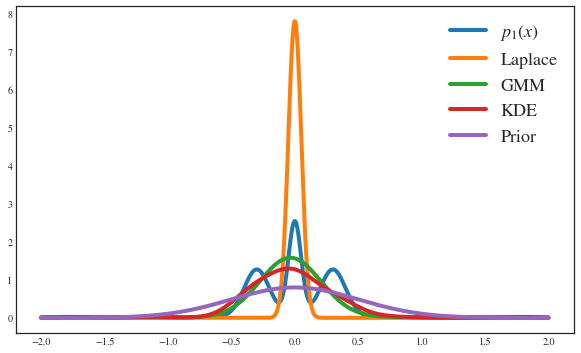

In [14]:
from steintorch.utils.dist_approximations import get_gaussian_mixture_approximation, get_laplace_approximation, get_kernel_density_approximation
from steintorch.kernel import MaternKernel, SquaredExponentialKernel
from steintorch.utils.cdf import get_1D_mixture_cdf, get_icdf

kde_kernel = SquaredExponentialKernel(dim=1) # kernel for KDE

torch.manual_seed(3)
P1_sample = P1.sample((100,)) # sample used to generate approximations
Q1_laplace = get_laplace_approximation(P1, mode=torch.Tensor([0]))
Q1_gmm, bic = get_gaussian_mixture_approximation(P1_sample, N=3, evaluate="bic")
print("GMM P1 bic: ", bic)

Q1_kde = get_kernel_density_approximation(P1_sample, kde_kernel)
Q1_kde.silvermans_rule()

Q1_prior = torch.distributions.Normal(torch.Tensor([0]), torch.Tensor([0.5]))

LIN = torch.linspace(-2,2,500)
plt.plot(LIN, P1.log_prob(LIN.unsqueeze(-1)).exp(), linewidth=4)
plt.plot(LIN, Q1_laplace.log_prob(LIN.unsqueeze(-1)).exp(), linewidth=4)
plt.plot(LIN, Q1_gmm.log_prob(LIN.unsqueeze(-1)).exp(), linewidth=4)
plt.plot(LIN, Q1_kde.log_prob(LIN.unsqueeze(-1)).exp().detach(), linewidth=4)
plt.plot(LIN, Q1_prior.log_prob(LIN.unsqueeze(-1)).exp().detach(), linewidth=4)

plt.legend(["$p_1(x)$","Laplace","GMM","KDE", "Prior"], prop={'size': 18})
plt.show()


#### $p_2$:

GMM P2 bic:  58.95900024896764


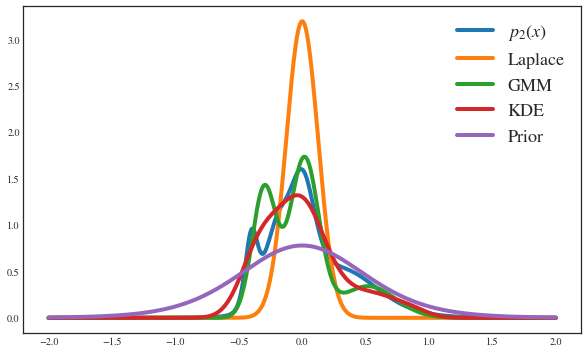

In [29]:
from steintorch.utils.dist_approximations import get_gaussian_mixture_approximation, get_laplace_approximation, get_kernel_density_approximation
from steintorch.kernel import MaternKernel, SquaredExponentialKernel
from steintorch.utils.cdf import get_1D_mixture_cdf, get_icdf

kde_kernel = SquaredExponentialKernel(dim=1) # kernel for KDE

torch.manual_seed(3)
P2_sample = P2.sample((100,)) # sample used to generate approximations
Q2_laplace = get_laplace_approximation(P2, mode=torch.Tensor([0]))
Q2_gmm, bic = get_gaussian_mixture_approximation(P2_sample, N=3, evaluate="bic")
print("GMM P2 bic: ", bic)

Q2_kde = get_kernel_density_approximation(P2_sample, kde_kernel)
Q2_kde.silvermans_rule()

Q2_prior = D.StudentT(10, torch.Tensor([0]), torch.Tensor([0.5]))

LIN = torch.linspace(-2,2,500)
plt.plot(LIN, P2.log_prob(LIN.unsqueeze(-1)).exp(), linewidth=4)
plt.plot(LIN, Q2_laplace.log_prob(LIN.unsqueeze(-1)).exp(), linewidth=4)
plt.plot(LIN, Q2_gmm.log_prob(LIN.unsqueeze(-1)).exp(), linewidth=4)
plt.plot(LIN, Q2_kde.log_prob(LIN.unsqueeze(-1)).exp().detach(), linewidth=4)
plt.plot(LIN, Q2_prior.log_prob(LIN.unsqueeze(-1)).exp().detach(), linewidth=4)

plt.legend(["$p_2(x)$","Laplace","GMM","KDE", "Prior"], prop={'size': 18})
plt.show()


## Computing GF-KSD of Sequences:

### $p_1$:

In [31]:
from steintorch.divergence.ksd import GradientFreeKSD
gf_KSD = GradientFreeKSD(None)

In [32]:
N = len(epsilon_seq1)

# converging sequence GF-KSD values
gfksd_laplace_conv1 = [[] for  i in range(3)] # laplace
gfksd_gmm_conv1 = [[] for  i in range(3)] # gmm
gfksd_kde_conv1 = [[] for i in range(3)] # kde
gfksd_prior_conv1 = [[] for  i in range(3)] # prior

# non-converging sequence GF-KSD values
gfksd_laplace_not_conv1 = [[] for  i in range(3)] # laplace
gfksd_gmm_not_conv1 = [[] for  i in range(3)] # gmm
gfksd_kde_not_conv1 = [[] for i in range(3)] # kde
gfksd_prior_not_conv1 = [[] for  i in range(3)] # prior


for j in range(3):
    for i in range(N):
        pi_i = tempered_sequence(epsilons_seqs[j][i], target_dist=P1, tempered_dist=tempering_dists[j])
        pibad_i = tempered_sequence(epsilons_seqs[j][i], target_dist=bad_target, tempered_dist=tempering_dists[j])

        epsilon = epsilons_seqs[j][i]
        t_dist = tempering_dists[j]
        
        w_mean = (t_dist.variance / epsilon * bad_target.mean + bad_target.variance / (1 - epsilon) * t_dist.mean) / (t_dist.variance / epsilon + bad_target.variance / (1 - epsilon))
        w_variance = 1 /  (epsilon / t_dist.variance + (1 - epsilon) / bad_target.variance)

        w = D.Normal(w_mean, w_variance.sqrt())

        uniform_mesh = torch.linspace(0,1,300)[1:-1]
        gauss_mesh = w.icdf(uniform_mesh).unsqueeze(1)

        score_Q1_prior = get_score(gauss_mesh.requires_grad_(True), Q1_prior).detach()
        score_Q1_laplace = get_score(gauss_mesh.requires_grad_(True), Q1_laplace).detach()
        score_Q1_kde = get_score(gauss_mesh.requires_grad_(True), Q1_kde).detach()
        score_Q1_gmm = get_score(gauss_mesh.requires_grad_(True), Q1_gmm).detach()

        gauss_mesh = gauss_mesh.detach()
        weights = (pi_i.log_prob(gauss_mesh).flatten() - w.log_prob(gauss_mesh).flatten()).exp()

        gf_ksd_q1_prior = gf_KSD.eval(gauss_mesh, P1.log_prob(gauss_mesh).flatten(), Q1_prior.log_prob(gauss_mesh).flatten(), score_Q1_prior, weights=weights)
        gf_ksd_q1_laplace = gf_KSD.eval(gauss_mesh, P1.log_prob(gauss_mesh).flatten(), Q1_laplace.log_prob(gauss_mesh).flatten(), score_Q1_laplace, weights=weights)
        gf_ksd_q1_kde = gf_KSD.eval(gauss_mesh, P1.log_prob(gauss_mesh).flatten(), Q1_kde.log_prob(gauss_mesh).flatten(), score_Q1_kde, weights=weights)
        gf_ksd_q1_gmm = gf_KSD.eval(gauss_mesh, P1.log_prob(gauss_mesh).flatten(), Q1_gmm.log_prob(gauss_mesh).flatten(), score_Q1_gmm, weights=weights)

        gfksd_prior_conv1[j].append(gf_ksd_q1_prior)
        gfksd_laplace_conv1[j].append(gf_ksd_q1_laplace)
        gfksd_kde_conv1[j].append(gf_ksd_q1_kde)
        gfksd_gmm_conv1[j].append(gf_ksd_q1_gmm)

    # axes[j][0].plot(LIN, P1.log_prob(LIN.unsqueeze(-1)).exp(), color="black", linewidth=THICKNESS+1)


for j in range(3):
    for i in range(N):
        pi_i = tempered_sequence(epsilons_seqs[j][i], target_dist=bad_target, tempered_dist=tempering_dists[j])
        # axes[j][1].plot(LIN, pi_i.log_prob(LIN.unsqueeze(-1)).exp(), color=good_ramps[j](cm_lin_space[i]), linewidth=THICKNESS, linestyle=ls, dashes=[4, 2])

        epsilon = epsilons_seqs[j][i]
        t_dist = tempering_dists[j]
        
        w_mean = (t_dist.variance / epsilon * bad_target.mean + bad_target.variance / (1 - epsilon) * t_dist.mean) / (t_dist.variance / epsilon + bad_target.variance / (1 - epsilon))
        w_variance = 1 /  (epsilon / t_dist.variance + (1 - epsilon) / bad_target.variance)

        w = D.Normal(w_mean, w_variance.sqrt())
        uniform_mesh = torch.linspace(0,1,300)[1:-1]
        gauss_mesh = w.icdf(uniform_mesh).unsqueeze(1)

        score_Q1_prior = get_score(gauss_mesh.requires_grad_(True), Q1_prior).detach()
        score_Q1_laplace = get_score(gauss_mesh.requires_grad_(True), Q1_laplace).detach()
        score_Q1_kde = get_score(gauss_mesh.requires_grad_(True), Q1_kde).detach()
        score_Q1_gmm = get_score(gauss_mesh.requires_grad_(True), Q1_gmm).detach()

        gauss_mesh = gauss_mesh.detach()
        weights = (pi_i.log_prob(gauss_mesh).flatten() - w.log_prob(gauss_mesh).flatten()).exp()

        gf_ksd_q1_prior = gf_KSD.eval(gauss_mesh, P1.log_prob(gauss_mesh).flatten(), Q1_prior.log_prob(gauss_mesh).flatten(), score_Q1_prior, weights=weights)
        gf_ksd_q1_laplace = gf_KSD.eval(gauss_mesh, P1.log_prob(gauss_mesh).flatten(), Q1_laplace.log_prob(gauss_mesh).flatten(), score_Q1_laplace, weights=weights)
        gf_ksd_q1_kde = gf_KSD.eval(gauss_mesh, P1.log_prob(gauss_mesh).flatten(), Q1_kde.log_prob(gauss_mesh).flatten(), score_Q1_kde, weights=weights)
        gf_ksd_q1_gmm = gf_KSD.eval(gauss_mesh, P1.log_prob(gauss_mesh).flatten(), Q1_gmm.log_prob(gauss_mesh).flatten(), score_Q1_gmm, weights=weights)

        gfksd_prior_not_conv1[j].append(gf_ksd_q1_prior)
        gfksd_laplace_not_conv1[j].append(gf_ksd_q1_laplace)
        gfksd_kde_not_conv1[j].append(gf_ksd_q1_kde)
        gfksd_gmm_not_conv1[j].append(gf_ksd_q1_gmm)
    

### $p_2$:

In [33]:
N = len(epsilon_seq1)

# converging sequence GF-KSD values
gfksd_laplace_conv2 = [[] for  i in range(3)] # laplace
gfksd_gmm_conv2 = [[] for  i in range(3)] # gmm
gfksd_kde_conv2 = [[] for i in range(3)] # kde
gfksd_prior_conv2 = [[] for  i in range(3)] # prior

# non-converging sequence GF-KSD values
gfksd_laplace_not_conv2 = [[] for  i in range(3)] # laplace
gfksd_gmm_not_conv2 = [[] for  i in range(3)] # gmm
gfksd_kde_not_conv2 = [[] for i in range(3)] # kde
gfksd_prior_not_conv2 = [[] for  i in range(3)] # prior


for j in range(3):
    for i in range(N):
        pi_i = tempered_sequence(epsilons_seqs[j][i], target_dist=P2, tempered_dist=tempering_dists[j])
        pibad_i = tempered_sequence(epsilons_seqs[j][i], target_dist=bad_target, tempered_dist=tempering_dists[j])

        epsilon = epsilons_seqs[j][i]
        t_dist = tempering_dists[j]
        
        w_mean = (t_dist.variance / epsilon * bad_target.mean + bad_target.variance / (1 - epsilon) * t_dist.mean) / (t_dist.variance / epsilon + bad_target.variance / (1 - epsilon))
        w_variance = 1 /  (epsilon / t_dist.variance + (1 - epsilon) / bad_target.variance)
        w = D.Normal(w_mean, w_variance.sqrt())
        uniform_mesh = torch.linspace(0,1,300)[1:-1]
        gauss_mesh = w.icdf(uniform_mesh).unsqueeze(1)

        score_Q2_prior = get_score(gauss_mesh.requires_grad_(True), Q2_prior).detach()
        score_Q2_laplace = get_score(gauss_mesh.requires_grad_(True), Q2_laplace).detach()
        score_Q2_kde = get_score(gauss_mesh.requires_grad_(True), Q2_kde).detach()
        score_Q2_gmm = get_score(gauss_mesh.requires_grad_(True), Q2_gmm).detach()

        gauss_mesh = gauss_mesh.detach()
        weights = (pi_i.log_prob(gauss_mesh).flatten() - w.log_prob(gauss_mesh).flatten()).exp()

        gf_ksd_q2_prior = gf_KSD.eval(gauss_mesh, P2.log_prob(gauss_mesh).flatten(), Q2_prior.log_prob(gauss_mesh).flatten(), score_Q2_prior, weights=weights)
        gf_ksd_q2_laplace = gf_KSD.eval(gauss_mesh, P2.log_prob(gauss_mesh).flatten(), Q2_laplace.log_prob(gauss_mesh).flatten(), score_Q2_laplace, weights=weights)
        gf_ksd_q2_kde = gf_KSD.eval(gauss_mesh, P2.log_prob(gauss_mesh).flatten(), Q2_kde.log_prob(gauss_mesh).flatten(), score_Q2_kde, weights=weights)
        gf_ksd_q2_gmm = gf_KSD.eval(gauss_mesh, P2.log_prob(gauss_mesh).flatten(), Q2_gmm.log_prob(gauss_mesh).flatten(), score_Q2_gmm, weights=weights)

        gfksd_prior_conv2[j].append(gf_ksd_q2_prior)
        gfksd_laplace_conv2[j].append(gf_ksd_q2_laplace)
        gfksd_kde_conv2[j].append(gf_ksd_q2_kde)
        gfksd_gmm_conv2[j].append(gf_ksd_q2_gmm)

for j in range(3):
    for i in range(N):
        pi_i = tempered_sequence(epsilons_seqs[j][i], target_dist=bad_target, tempered_dist=tempering_dists[j])

        epsilon = epsilons_seqs[j][i]
        t_dist = tempering_dists[j]
        
        w_mean = (t_dist.variance / epsilon * bad_target.mean + bad_target.variance / (1 - epsilon) * t_dist.mean) / (t_dist.variance / epsilon + bad_target.variance / (1 - epsilon))
        w_variance = 1 /  (epsilon / t_dist.variance + (1 - epsilon) / bad_target.variance)

        w = D.Normal(w_mean, w_variance.sqrt())
        uniform_mesh = torch.linspace(0,1,300)[1:-1]
        gauss_mesh = w.icdf(uniform_mesh).unsqueeze(1)

        score_Q2_prior = get_score(gauss_mesh.requires_grad_(True), Q2_prior).detach()
        score_Q2_laplace = get_score(gauss_mesh.requires_grad_(True), Q2_laplace).detach()
        score_Q2_kde = get_score(gauss_mesh.requires_grad_(True), Q2_kde).detach()
        score_Q2_gmm = get_score(gauss_mesh.requires_grad_(True), Q2_gmm).detach()

        gauss_mesh = gauss_mesh.detach()
        weights = (pi_i.log_prob(gauss_mesh).flatten() - w.log_prob(gauss_mesh).flatten()).exp()

        gf_ksd_q2_prior = gf_KSD.eval(gauss_mesh, P2.log_prob(gauss_mesh).flatten(), Q2_prior.log_prob(gauss_mesh).flatten(), score_Q2_prior, weights=weights)
        gf_ksd_q2_laplace = gf_KSD.eval(gauss_mesh, P2.log_prob(gauss_mesh).flatten(), Q2_laplace.log_prob(gauss_mesh).flatten(), score_Q2_laplace, weights=weights)
        gf_ksd_q2_kde = gf_KSD.eval(gauss_mesh, P2.log_prob(gauss_mesh).flatten(), Q2_kde.log_prob(gauss_mesh).flatten(), score_Q2_kde, weights=weights)
        gf_ksd_q2_gmm = gf_KSD.eval(gauss_mesh, P2.log_prob(gauss_mesh).flatten(), Q2_gmm.log_prob(gauss_mesh).flatten(), score_Q2_gmm, weights=weights)

        gfksd_prior_not_conv2[j].append(gf_ksd_q2_prior)
        gfksd_laplace_not_conv2[j].append(gf_ksd_q2_laplace)
        gfksd_kde_not_conv2[j].append(gf_ksd_q2_kde)
        gfksd_gmm_not_conv2[j].append(gf_ksd_q2_gmm)
    

## Plotting Convergence

#### $p_1$:

/var/folders/y9/f2jq2rkn6h16kl4g9j02c2800000gn/T/ipykernel_27979/2690954908.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


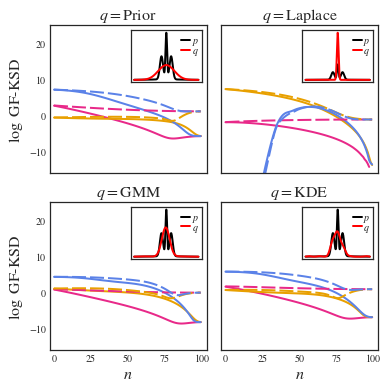

In [35]:
import matplotlib.transforms as mtrans
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axes = plt.subplots(2,2)
fig.set_size_inches(5.5, 5.5)

min_y, max_y = -16, 25
XX = torch.Tensor([j for j in range(N)])
plot_y_range = False
THICKNESS = 2

value_col = .9
colors = []

axes[0][1].plot(XX, torch.Tensor(gfksd_laplace_conv1[0]).detach().log(), linewidth=THICKNESS, color=good_ramps[0](value_col))
axes[0][1].plot(XX, torch.Tensor(gfksd_laplace_conv1[1]).detach().log(), linewidth=THICKNESS, color=good_ramps[1](value_col))
axes[0][1].plot(XX, torch.Tensor(gfksd_laplace_conv1[2]).detach().log(), linewidth=THICKNESS, color=good_ramps[2](value_col))
axes[0][1].plot(XX, torch.Tensor(gfksd_laplace_not_conv1[0]).detach().log(), linewidth=THICKNESS, color=good_ramps[0](value_col), linestyle=ls,  dashes=[7, 2])
axes[0][1].plot(XX, torch.Tensor(gfksd_laplace_not_conv1[1]).detach().log(), linewidth=THICKNESS, color=good_ramps[1](value_col), linestyle=ls, dashes=[7, 2])
axes[0][1].plot(XX, torch.Tensor(gfksd_laplace_not_conv1[2]).detach().log(), linewidth=THICKNESS, color=good_ramps[2](value_col), linestyle=ls, dashes=[7, 2])

for i in range(3):
    axes[1][0].plot(XX, torch.Tensor(gfksd_gmm_conv1[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col))
    axes[1][1].plot(XX, torch.Tensor(gfksd_kde_conv1[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col))
    axes[0][0].plot(XX, torch.Tensor(gfksd_prior_conv1[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col))

for i in range(3):
    axes[1][0].plot(XX, torch.Tensor(gfksd_gmm_not_conv1[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col), linestyle=ls,  dashes=[7, 2])
    axes[1][1].plot(XX, torch.Tensor(gfksd_kde_not_conv1[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col), linestyle=ls,  dashes=[7, 2])
    axes[0][0].plot(XX, torch.Tensor(gfksd_prior_not_conv1[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col), linestyle=ls,  dashes=[7, 2])

axes[0][0].set_title("$q=$Prior", fontsize=16)
axes[0][1].set_title("$q=$Laplace", fontsize=16)
axes[1][0].set_title("$q=$GMM", fontsize=16)
axes[1][1].set_title("$q=$KDE", fontsize=16)

LIN = torch.linspace(-2,2,500)

axes[0][0].xaxis.set_ticklabels([])
axes[0][0].xaxis.set_ticks_position('none') 

axes[0][1].xaxis.set_ticklabels([])
axes[0][1].xaxis.set_ticks_position('none') 

axes[0][1].yaxis.set_ticklabels([])
axes[0][1].yaxis.set_ticks_position('none') 

axes[1][1].yaxis.set_ticklabels([])
axes[1][1].yaxis.set_ticks_position('none') 

axes[0][0].set_ylabel("$\log$ GF-KSD", fontsize=16)
axes[1][0].set_ylabel("$\log$ GF-KSD", fontsize=16)


axes[1][0].set_xlabel("$n$", fontsize=16)
axes[1][1].set_xlabel("$n$", fontsize=16)


for i in range(2):
    for j in range(2):
        axes[i][j].set_ylim(min_y,max_y)
        axes[i][j].set_xlim(-3,103)


# inset axes:

inset_width = '45%'
inset_height = '35%'
axins1 = inset_axes(axes[0][0], width=inset_width, height=inset_height, loc=1) #prior
axins1.plot(LIN, P1.log_prob(LIN.unsqueeze(-1)).exp(), linewidth=THICKNESS, label = '$p$', color="black")
axins1.plot(LIN, Q1_prior.log_prob(LIN.unsqueeze(-1)).exp().detach(), linewidth=THICKNESS, label='$q$', color="red")
axins1.legend(loc=1, bbox_to_anchor=(1.095,1.07), fontsize=10, labelspacing=-0.2, handlelength=0.9, handletextpad=0.15)

axins2 = inset_axes(axes[0][1], width=inset_width, height=inset_height, loc=1) #laplace
axins2.plot(LIN, P1.log_prob(LIN.unsqueeze(-1)).exp(), linewidth=THICKNESS,  label = '$p$', color="black")
axins2.plot(LIN, Q1_laplace.log_prob(LIN.unsqueeze(-1)).exp(), linewidth=THICKNESS, label="$q$", color="red")
axins2.legend(loc=1, bbox_to_anchor=(1.095,1.07), fontsize=10, labelspacing=-0.2, handlelength=0.9, handletextpad=0.15)


axins3 = inset_axes(axes[1][0], width=inset_width, height=inset_height, loc=1) #GMM
axins3.plot(LIN, P1.log_prob(LIN.unsqueeze(-1)).exp(), linewidth=THICKNESS,  label = '$p$', color="black")
axins3.plot(LIN, Q1_gmm.log_prob(LIN.unsqueeze(-1)).exp(), linewidth=THICKNESS, label="$q$", color="red")
axins3.legend(loc=1, bbox_to_anchor=(1.095,1.07), fontsize=10, labelspacing=-0.2, handlelength=0.9, handletextpad=0.15)


axins4 = inset_axes(axes[1][1], width=inset_width, height=inset_height, loc=1) #KDE
axins4.plot(LIN, P1.log_prob(LIN.unsqueeze(-1)).exp(), linewidth=THICKNESS,  label = '$p$', color="black")
axins4.plot(LIN, Q1_kde.log_prob(LIN.unsqueeze(-1)).exp().detach(), linewidth=THICKNESS, label="$q$", color="red")
axins4.legend(loc=1, bbox_to_anchor=(1.095,1.07), fontsize=10, labelspacing=-0.2, handlelength=0.9, handletextpad=0.15)

for axi in [axins1, axins2, axins3, axins4]:
    axi.tick_params(labelleft=False, labelbottom=False)


fig.tight_layout()
plt.show()


#### $p_2$:

/var/folders/y9/f2jq2rkn6h16kl4g9j02c2800000gn/T/ipykernel_27979/3252128973.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


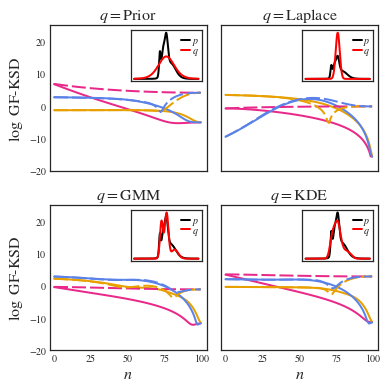

In [36]:
import matplotlib.transforms as mtrans
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axes = plt.subplots(2,2)
fig.set_size_inches(5.5, 5.5)

min_y, max_y = -20, 25
XX = torch.Tensor([j for j in range(N)])
plot_y_range = False
THICKNESS = 2

value_col = .9
colors = []

axes[0][1].plot(XX, torch.Tensor(gfksd_laplace_conv2[0]).detach().log(), linewidth=THICKNESS, color=good_ramps[0](value_col))
axes[0][1].plot(XX, torch.Tensor(gfksd_laplace_conv2[1]).detach().log(), linewidth=THICKNESS, color=good_ramps[1](value_col))
axes[0][1].plot(XX, torch.Tensor(gfksd_laplace_conv2[2]).detach().log(), linewidth=THICKNESS, color=good_ramps[2](value_col))
axes[0][1].plot(XX, torch.Tensor(gfksd_laplace_not_conv2[0]).detach().log(), linewidth=THICKNESS, color=good_ramps[0](value_col), linestyle=ls,  dashes=[7, 2])
axes[0][1].plot(XX, torch.Tensor(gfksd_laplace_not_conv2[1]).detach().log(), linewidth=THICKNESS, color=good_ramps[1](value_col), linestyle=ls, dashes=[7, 2])
axes[0][1].plot(XX, torch.Tensor(gfksd_laplace_not_conv2[2]).detach().log(), linewidth=THICKNESS, color=good_ramps[2](value_col), linestyle=ls, dashes=[7, 2])

for i in range(3):
    axes[1][0].plot(XX, torch.Tensor(gfksd_gmm_conv2[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col))
    axes[1][1].plot(XX, torch.Tensor(gfksd_kde_conv2[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col))
    axes[0][0].plot(XX, torch.Tensor(gfksd_prior_conv2[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col))

for i in range(3):
    axes[1][0].plot(XX, torch.Tensor(gfksd_gmm_not_conv2[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col), linestyle=ls,  dashes=[7, 2])
    axes[1][1].plot(XX, torch.Tensor(gfksd_kde_not_conv2[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col), linestyle=ls,  dashes=[7, 2])
    axes[0][0].plot(XX, torch.Tensor(gfksd_prior_not_conv2[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col), linestyle=ls,  dashes=[7, 2])

axes[0][0].set_title("$q=$Prior", fontsize=16)
axes[0][1].set_title("$q=$Laplace", fontsize=16)
axes[1][0].set_title("$q=$GMM", fontsize=16)
axes[1][1].set_title("$q=$KDE", fontsize=16)

LIN = torch.linspace(-2,2,500)

axes[0][0].xaxis.set_ticklabels([])
axes[0][0].xaxis.set_ticks_position('none') 

axes[0][1].xaxis.set_ticklabels([])
axes[0][1].xaxis.set_ticks_position('none') 

axes[0][1].yaxis.set_ticklabels([])
axes[0][1].yaxis.set_ticks_position('none') 

axes[1][1].yaxis.set_ticklabels([])
axes[1][1].yaxis.set_ticks_position('none') 

axes[0][0].set_ylabel("$\log$ GF-KSD", fontsize=16)
axes[1][0].set_ylabel("$\log$ GF-KSD", fontsize=16)


axes[1][0].set_xlabel("$n$", fontsize=16)
axes[1][1].set_xlabel("$n$", fontsize=16)


for i in range(2):
    for j in range(2):
        axes[i][j].set_ylim(min_y,max_y)
        axes[i][j].set_xlim(-3,103)


# inset axes:

inset_width = '45%'
inset_height = '35%'
axins1 = inset_axes(axes[0][0], width=inset_width, height=inset_height, loc=1) #prior
axins1.plot(LIN, P2.log_prob(LIN.unsqueeze(-1)).exp(), linewidth=THICKNESS, label = '$p$', color="black")
axins1.plot(LIN, Q2_prior.log_prob(LIN.unsqueeze(-1)).exp().detach(), linewidth=THICKNESS, label='$q$', color="red")
axins1.legend(loc=1, bbox_to_anchor=(1.095,1.07), fontsize=10, labelspacing=-0.2, handlelength=0.9, handletextpad=0.15)

axins2 = inset_axes(axes[0][1], width=inset_width, height=inset_height, loc=1) #laplace
axins2.plot(LIN, P2.log_prob(LIN.unsqueeze(-1)).exp(), linewidth=THICKNESS,  label = '$p$', color="black")
axins2.plot(LIN, Q2_laplace.log_prob(LIN.unsqueeze(-1)).exp(), linewidth=THICKNESS, label="$q$", color="red")
axins2.legend(loc=1, bbox_to_anchor=(1.095,1.07), fontsize=10, labelspacing=-0.2, handlelength=0.9, handletextpad=0.15)


axins3 = inset_axes(axes[1][0], width=inset_width, height=inset_height, loc=1) #GMM
axins3.plot(LIN, P2.log_prob(LIN.unsqueeze(-1)).exp(), linewidth=THICKNESS,  label = '$p$', color="black")
axins3.plot(LIN, Q2_gmm.log_prob(LIN.unsqueeze(-1)).exp(), linewidth=THICKNESS, label="$q$", color="red")
axins3.legend(loc=1, bbox_to_anchor=(1.095,1.07), fontsize=10, labelspacing=-0.2, handlelength=0.9, handletextpad=0.15)


axins4 = inset_axes(axes[1][1], width=inset_width, height=inset_height, loc=1) #KDE
axins4.plot(LIN, P2.log_prob(LIN.unsqueeze(-1)).exp(), linewidth=THICKNESS,  label = '$p$', color="black")
axins4.plot(LIN, Q2_kde.log_prob(LIN.unsqueeze(-1)).exp().detach(), linewidth=THICKNESS, label="$q$", color="red")
axins4.legend(loc=1, bbox_to_anchor=(1.095,1.07), fontsize=10, labelspacing=-0.2, handlelength=0.9, handletextpad=0.15)

for axi in [axins1, axins2, axins3, axins4]:
    axi.tick_params(labelleft=False, labelbottom=False)


fig.tight_layout()
plt.show()
